# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# Load Metas Data

In [2]:
def load_meta_df(fname):

    # column names
    names = [
        "ts",
        "ip.src",
        "ip.dst",
        "udp.length.int",
        "udp.srcport",
        "udp.dstport",
        "protocol",
        "quic.version",
        "gquic.version",
        "info",
        "quic.crypto.length",
        "quic.padding_length",
        "quic.long.packet_type",
        "quic.connection.number",
        "quic.fixed_bit",
        "quic.packet_length",
        "quic.packet_number",
        "quic.scid",
        "quic.dcid",
        "quic.length",
    ]

    # columns used in this analysis
    use_cols = [
     "ts",
     "ip.src",
     "ip.dst",
     "udp.length.int",
    ]

    # column types
    dtype = {
        "ip.src": str,
        "ip.dst": str,
        "udp.length.int": "Int64",
    }
    
    # load dataframe
    df = pd.read_csv(fname, sep="|", header=None, index_col=False,
                     names=names, usecols=use_cols,
                     infer_datetime_format=True, parse_dates=["ts"],
                     low_memory=True, dtype=dtype)

    # sanitize: remove scanning location traffic (client requests)
    df = df[df["ip.src"]!="141.22.213.54"]

    # sanitize: keep only Meta hosts
    set_meta_ips = set(pd.read_csv("../data/csv/meta_host_addresses.csv.zst",
                                   header=None).squeeze())
    df = df[df["ip.src"].isin(set_meta_ips)]
    
    # extend: substract 8 Byte UDP header to get payload size
    df["udp.payloadlength.int"] = df["udp.length.int"]-8
    
    # extend: parse host ID of /24 prefix
    df["ip.src.host"] = df["ip.src"].str.split(".").str[3].astype(int)
    
    # extend: set names for host octets
    dict_meta_names = pd.read_csv("../data/csv/meta_host_names.csv.zst",
                                  index_col="suffix").squeeze().to_dict()
    df["ip.src.host.names"] = df["ip.src.host"].map(dict_meta_names)
    
    return df

In [3]:
df_meta_08 = load_meta_df("../data/csv/quic-incomplete-handshakes-2022-08-03.csv.zst")
df_meta_08.head()

,ts,ip.src,ip.dst,udp.length.int,udp.payloadlength.int,ip.src.host,ip.src.host.names
21,2022-08-03 14:13:10.880409,69.171.250.60,141.22.213.54,1240,1232,60,whatsapp.net
22,2022-08-03 14:13:10.880409,69.171.250.60,141.22.213.54,1240,1232,60,whatsapp.net
23,2022-08-03 14:13:10.880409,69.171.250.60,141.22.213.54,1240,1232,60,whatsapp.net
24,2022-08-03 14:13:10.880409,69.171.250.60,141.22.213.54,737,729,60,whatsapp.net
25,2022-08-03 14:13:10.880409,69.171.250.60,141.22.213.54,88,80,60,whatsapp.net


In [4]:
df_meta_10 = load_meta_df("../data/csv/quic-incomplete-handshakes-2022-10-12.csv.zst")
df_meta_10.head()

,ts,ip.src,ip.dst,udp.length.int,udp.payloadlength.int,ip.src.host,ip.src.host.names
22,2022-10-12 14:34:11.387495,31.13.92.52,141.22.213.54,1240,1232,52,"whatsapp.net, instagram.com, igcdn.com"
23,2022-10-12 14:34:11.388953,31.13.92.52,141.22.213.54,1240,1232,52,"whatsapp.net, instagram.com, igcdn.com"
24,2022-10-12 14:34:11.389252,31.13.92.52,141.22.213.54,1240,1232,52,"whatsapp.net, instagram.com, igcdn.com"
25,2022-10-12 14:34:11.389252,31.13.92.52,141.22.213.54,1240,1232,52,"whatsapp.net, instagram.com, igcdn.com"
26,2022-10-12 14:34:11.389252,31.13.92.52,141.22.213.54,739,731,52,"whatsapp.net, instagram.com, igcdn.com"


# Plot Data

In [5]:
def plot_ampl_factors_hosts(df_meta, tag, legend=True):

    # calculate amplification factor per IP, make sure it's sorted by host octet
    client_initial_size = 1252
    plot_data  = df_meta.groupby(["ip.src.host", "ip.src"],
                                    as_index=False, sort=True).agg(
                                        {"udp.payloadlength.int": "sum",
                                         "ip.src.host.names": "first"})
    plot_data["udp.ampl_factor"] = plot_data["udp.payloadlength.int"] /\
                                        client_initial_size
    
    # finally plot
    fig, ax = plt.subplots(figsize=(11,2.5))
    sns.barplot(data=plot_data, x="ip.src.host", y = "udp.ampl_factor",
                ax=ax, hue="ip.src.host.names", dodge=False, ci=95)
    plt.xticks(rotation=90)
    ax.set_xlabel("Host Octet for /24 Prefixes")
    ax.set_ylabel("Amplification Factor")
    ax.set_ylim((0,30))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.axhline(3, color="k", ls="--")
    plt.tight_layout()
    if not legend:
        ax.get_legend().remove()
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.97),
                  ncol=2, fancybox=False, shadow=False,)
        
    # save and show
    plt.savefig(f"./plots/meta-amplification-by-host-octet-{tag}.pdf", bbox_inches="tight")
    plt.savefig(f"./plots/meta-amplification-by-host-octet-{tag}.png", bbox_inches="tight", dpi=200)
    plt.show()

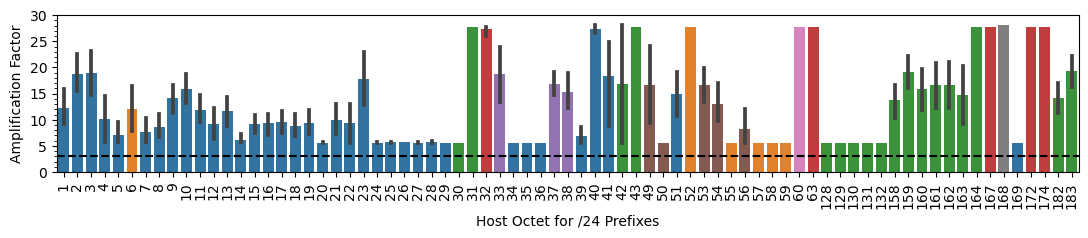

In [6]:
plot_ampl_factors_hosts(df_meta_08, "predisclosure", legend=False)

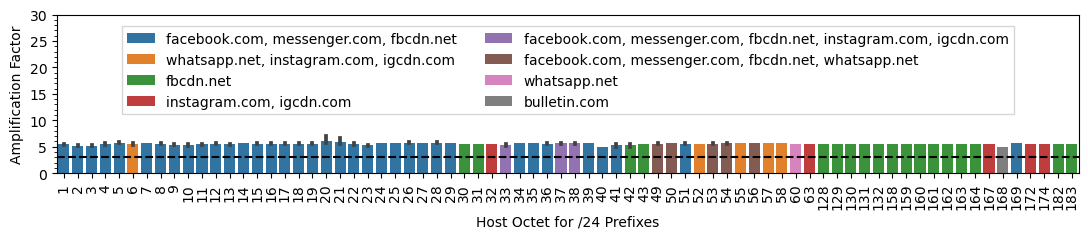

In [7]:
plot_ampl_factors_hosts(df_meta_10, "postdisclosure", legend=True)